# Problem Set 5

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

new_line = '\n'
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
sns.set(font_scale=1.5, rc={'text.usetex' : True,})
%config InlineBackend.figure_format='retina'

In [1]:
# simulate stock prices with antithetic variables to reduce variance
def simulate_gbm(s_0, mu, sigma, n_sims, T, antithetic_var=False):
    
    """
    simulation of stock prices with antithetic variables to reduce variance
    """
    
    dt = 1/np.sqrt(n_sims)
    step = int(T/dt)
    
    # Antithetic variables
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), step + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, step + 1))
  
    St = np.zeros((n_sims, step + 1))
    St[:, 0] = s_0
    
    for i in range (1, step + 1):
        St[:, i] = St[:, i - 1]*np.exp((mu - 1/2*np.power(sigma, 2))*dt + sigma*dW[:, i - 1])
    
    return St


In [16]:
# Polynomials function
def laguerre(x,k):
    x = np.array(x)
    n = len(x)
    
    s1 = np.exp(-x/2)
    s2 = np.exp(-x/2)*(1-x)
    s3 = np.exp(-x/2)*(1-2*x+x**2/2)
    s4 = np.exp(-x/2)*(1-3*x+3*x**2/2-x**3/6)
    
    if k==1: return s1
    elif k==2: return np.array([s1,s2]).reshape(2,n)
    elif k==3: return np.array([s1,s2,s3]).reshape(3,n)
    elif k==4: return np.array([s1,s2,s3,s4]).reshape(4,n)
    
def hermite(x,k):
    x = np.array(x)
    n = len(x)
    
    s1 = [1] * n
    s2 = 2*x
    s3 = 4*x**2-2
    s4 = 8*x**3-12*x
    
    if k==1: return s1
    elif k==2: return np.array([s1,s2]).reshape(2,n)
    elif k==3: return np.array([s1,s2,s3]).reshape(3,n)
    elif k==4: return np.array([s1,s2,s3,s4]).reshape(4,n)
    
def monomials(x,k):
    x = np.array(x)
    n = len(x)
    
    s1 = [1] * n
    s2 = x
    s3 = x**2
    s4 = x**3
    
    if k==1: return s1
    elif k==2: return np.array([s1,s2]).reshape(2,n)
    elif k==3: return np.array([s1,s2,s3]).reshape(3,n)
    elif k==4: return np.array([s1,s2,s3,s4]).reshape(4,n)
    
def basis_function(x,k,method):
    if method.lower() == 'laguerre':
        return laguerre(x,k)
    elif method.lower() =='hermite':
        return hermite(x,k)
    elif method.lower() == 'monomials':
        return monomials(x,k)


In [67]:
def LCSM(s0,strike,T,r,sigma,path,k,method):
    """
    Least-Square Monte Carlo Function
    Method: function of choosing polynomials in ['laguerre','hermite','monomials']
    """
    dt = 1/np.sqrt(path)
    step = int(T/dt)
    disc = np.exp(-r*dt)
    
    # scale stock price by strike price
    St = simulate_gbm(s_0=s0,mu=r,sigma=sigma,n_sims=path,T=T,antithetic_var=True)/strike
    # cashflow matrix
    payoff_matrix = np.maximum(1 - St, np.zeros_like(St))
    # continuation matrix
    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]
    
    for i in range(step - 1, 0 , -1):

        X = St[:,i]
        y = value_matrix[:,i+1]*disc
        
        X = basis_function(X,k,method)
        A = np.dot(X,X.T)
        b = np.dot(X,y)
        
        # find coefficients
        coef = np.dot(np.linalg.inv(A), b)
        # calculate continuation value with coefficients
        continuation_value = np.dot(X.T,coef)
    
        value_matrix[:, i] = np.where(
            payoff_matrix[:, i] > continuation_value,
            payoff_matrix[:, i],
            value_matrix[:, i + 1] * disc
        )
    
    
    option = np.mean(value_matrix[:, 1] * disc)* strike
    
    return option

# LCSM(s0=40,r=0.06, sigma=0.2, path=10,T=2,strike=40,k=4,method="monomials")

In [37]:
s0 = 40
sigma = 0.2
rf = 0.06
N = 100000
strike = 40
T = [0.5,1,2]
k = [2,3,4]

### (a) Laguerre Polynomials

In [38]:
a_2 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=2,method='laguerre')
    a_2.append(price)
a_3 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=3,method='laguerre')
    a_3.append(price)
a_4 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=4,method='laguerre')
    a_4.append(price)

In [39]:
answer_a = pd.DataFrame(list(zip(a_2,a_3,a_4)))
answer_a.index=['T=0.5','T=1','T=2']
answer_a.columns = ['K=2','K=3','K=4']
answer_a

,K=2,K=3,K=4
T=0.5,1.585069,1.702291,1.723197
T=1,2.018832,2.169624,2.216167
T=2,2.485110,2.643543,2.750408


### (b) Hermite Polynomials

In [40]:
b_2 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=2,method='hermite')
    b_2.append(price)
b_3 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=3,method='hermite')
    b_3.append(price)
b_4 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=4,method='hermite')
    b_4.append(price)

In [41]:
answer_b = pd.DataFrame(list(zip(b_2,b_3,b_4)))
answer_b.index=['T=0.5','T=1','T=2']
answer_b.columns = ['K=2','K=3','K=4']
answer_b

,K=2,K=3,K=4
T=0.5,1.572054,1.681312,1.726638
T=1,1.995157,2.120473,2.220375
T=2,2.448517,2.577618,2.729778


### (c) Simple Monomials

In [42]:
c_2 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=2,method='monomials')
    c_2.append(price)
c_3 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=3,method='monomials')
    c_3.append(price)
c_4 = []
for t in T:
    price = LCSM(s0=s0,strike=strike,T=t,r=rf,sigma=sigma,path=N,k=4,method='monomials')
    c_4.append(price)

In [43]:
answer_c = pd.DataFrame(list(zip(c_2,c_3,c_4)))
answer_c.index=['T=0.5','T=1','T=2']
answer_c.columns = ['K=2','K=3','K=4']
answer_c

,K=2,K=3,K=4
T=0.5,1.586788,1.677614,1.726501
T=1,1.998103,2.127337,2.225514
T=2,2.469076,2.567499,2.716316


### (d)

In [54]:
def parameters(r,sigma,N,T,formula):
    dt = T/N
    if formula == 'a':
        c = 0.5 * (np.exp(-r*dt) + np.exp( (r+sigma**2)*dt) )
        d = c - np.sqrt(c**2 -1)
        u = 1/d
        p = (np.exp(r*dt) -d) / (u-d)
    elif formula == 'b':
        u = np.exp(r*dt)*(1+np.sqrt(np.exp(sigma**2*dt)-1))
        d = np.exp(r*dt)*(1-np.sqrt(np.exp(sigma**2*dt)-1))
        p = 0.5
    elif formula =='c':
        u = np.exp((r-sigma**2/2)*dt + sigma*np.sqrt(dt))
        d = np.exp((r-sigma**2/2)*dt - sigma*np.sqrt(dt))
        p=0.5
    elif formula =='d':
        u = np.exp(sigma*np.sqrt(dt))
        d = np.exp(-sigma*np.sqrt(dt))
        p = 1/2 + 1/2*((r-sigma**2/2)*np.sqrt(dt))/sigma
    
    return u, d, p, N

def binoAmer_fast(s0,N,k,r,T,sigma,option_type,formula):
    dt = T/N
    params = parameters(r,sigma,N,T,formula)
    u = params[0]
    d = params[1]
    p = params[2]
    disc = np.exp(-r*dt)
    
    S = s0* u**np.arange(0,N+1,1)*d**np.arange(N,-1,-1)       # stock prices at last step

    if option_type.lower()=='c':
        C = np.maximum(0,S - k)
    else:
        C = np.maximum(0,k - S)
   
    for i in np.arange(N-1,-1,-1):
        S = s0* u**np.arange(0,i+1,1)*d**np.arange(i,-1,-1)
   
        C[:i+1] = disc * (p * C[1:i+2] + (1-p)* C[0:i+1])
   
        C = C[:-1]
       
        if option_type.lower()=='c':
            C = np.maximum(C,S - k)
        else:
            C = np.maximum(C,k - S)
        
    return C[0]

In [64]:
# compare to binomial prices 
binoPrice = []
for t in T:
    price = binoAmer_fast(s0=s0,N=158,k=strike,r=rf,T=t,sigma=sigma,option_type='put',formula='c')
    binoPrice.append(price)

In [65]:
binop = pd.DataFrame(binoPrice,index=['T=0.5','T=1','T=2'],columns=['Price'])
binop

,Price
T=0.5,1.797425
T=1,2.320763
T=2,2.890038


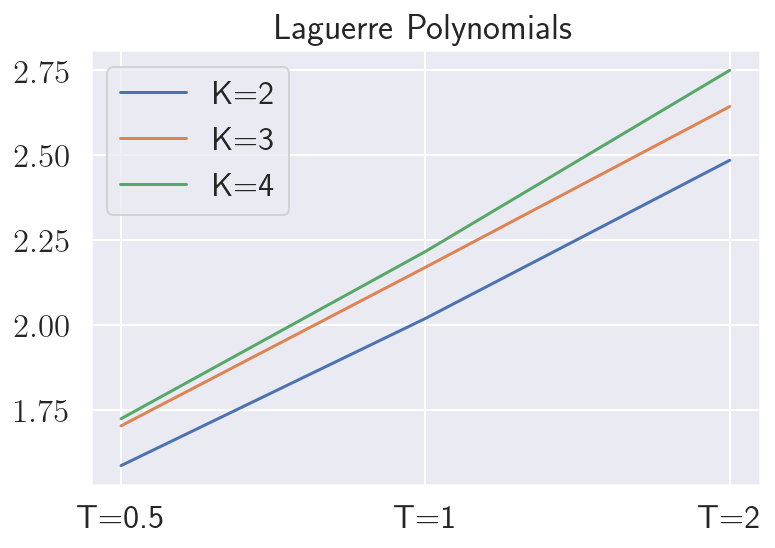

In [45]:
plt.figure()

plt.plot(answer_a)
plt.legend(answer_a.columns)
plt.title('Laguerre Polynomials')
plt.show()

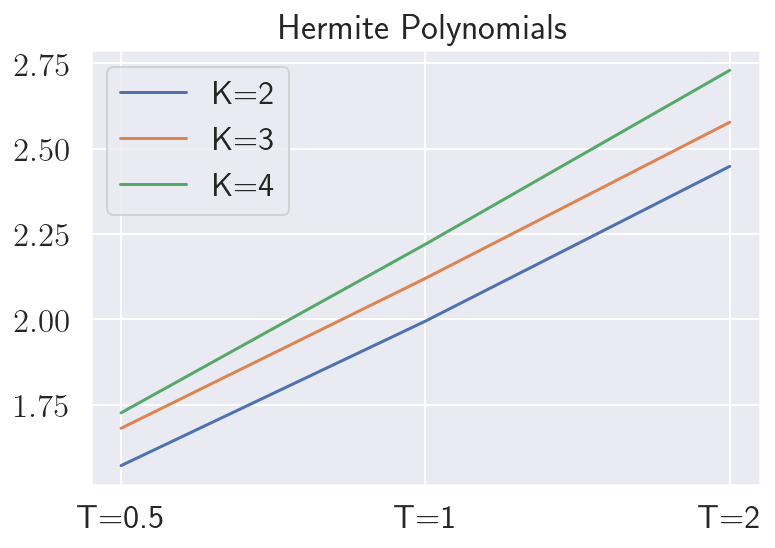

In [46]:
plt.figure()

plt.plot(answer_b)
plt.legend(answer_b.columns)
plt.title('Hermite Polynomials')

plt.show()

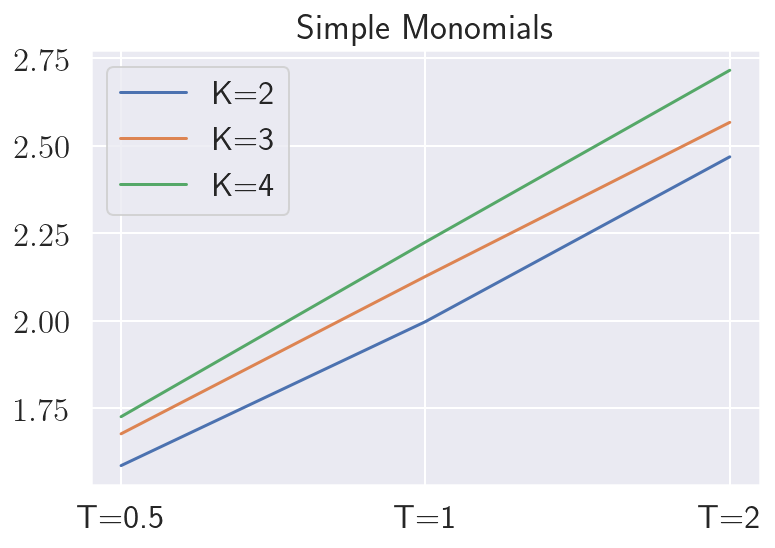

In [47]:
plt.figure()

plt.plot(answer_c)
plt.legend(answer_c.columns)
plt.title('Simple Monomials')
plt.show()

In [17]:
# ## class material example
# k=97.5
# r =0.05
# dt = 3/3
# disc = np.exp(-r*dt)
# path = 10
# step = 3
# ss = np.array([[100,92.8,108.8,121.11],
#              [100,100.1,94.2,92.1],
#               [100,98.87,93.11,97.8],
#               [100,96.34,93.11,90.36],
#               [100,102.14,100.05,96.43],
#               [100,98.3,110.21,99.2],
#               [100,102.87,120.1,128.43],
#               [100,110.21,98.2,94.5],
#               [100,89.87,93.8,90],
#               [100,86.12,90.21,98.34]])
# # 0: do nothing, 1: exercise
# payoff = np.zeros_like(ss)
# payoff= np.maximum(k -ss,np.zeros_like(ss))
# index = np.zeros_like(ss)
# index[:,step] = np.where(k > ss[:,step],1,0)
# continue_matrix = np.zeros_like(payoff)
# continue_matrix[:,step] = payoff[:,step]


# for i in range(step-1,0,-1):
    
#     in_the_money_path = np.where(payoff[:,i]*disc >0)[0]
#     X = ss[in_the_money_path,i]
#     y = continue_matrix[in_the_money_path,i+1]*disc
    
#     X = basis_function(X,3,method='hermite')
#     A = np.dot(X,X.T)
#     b = np.dot(X,y)
#     coef = np.dot(np.linalg.inv(A), b)
    
#     continue_matrix[in_the_money_path,i] = np.dot(X.T,coef)
#     exercise_value = payoff[in_the_money_path,i]
   
#     index[in_the_money_path,i] = np.where(exercise_value>continue_matrix[in_the_money_path,i],1,0)
#     continue_matrix[in_the_money_path,i] = np.maximum(exercise_value,continue_matrix[in_the_money_path,i])
    
# #     for j in range(path):
# #         if index[j,i] ==1:
# #             index[j,i+1:] = 0
            
#     continue_matrix[in_the_money_path,i+1] *= index[in_the_money_path,i+1]
   
#     continue_matrix[:,i] = np.maximum(disc* continue_matrix[:,i+1],continue_matrix[:,i])

#     for j in range(path):
#         if index[j,i] ==1:
#             index[j,i+1:] = 0
    
# optimal_matrix = np.ones_like(payoff) * index * payoff
# dt_array = np.exp(-r*dt*np.arange(1,step+1,1))
# avg_payoff = np.sum(optimal_matrix,axis=0)[1:] # exclude the initial price
# option_price = np.dot(avg_payoff,dt_array)/path

# # print(f"option price: {option_price} {new_line} \
# #       index matrix : {new_line} {index} {new_line}  \
# #       optimal exercise decision{new_line} {optimal_matrix}")


In [25]:
# def LCSM(s0,strike,T,r,sigma,path,k,method):
    
#     dt = 1/np.sqrt(path)
#     step = int(T/dt)
#     disc = np.exp(-r*dt)
    
#     St = simulate_gbm(s_0=s0,mu=r,sigma=sigma,n_sims=path,T=T,antithetic_var=True)/strike
    
#     payoff_matrix = np.maximum(1 - St, np.zeros_like(St))
    
#     index_matrix = np.zeros_like(payoff_matrix)
#     index_matrix[:,-1] = np.where(payoff_matrix[:,-1]>0,1,0)
    
#     value_matrix = np.zeros_like(payoff_matrix)
#     value_matrix[:, -1] = payoff_matrix[:, -1]
    
#     for i in range(step - 1, 0 , -1):
#         in_the_money_path = np.where(payoff_matrix[:,i]>0)[0]
        
#         X = St[in_the_money_path,i]
#         y = value_matrix[in_the_money_path,i+1]*disc
        
#         X = basis_function(X,k,method)
#         A = np.dot(X,X.T)
#         b = np.dot(X,y)
#         # find betas
#         coef = np.dot(np.linalg.inv(A), b)
        
#         continuation_value = np.dot(X.T,coef)
    
#         value_matrix[in_the_money_path, i] = np.where(
#             payoff_matrix[in_the_money_path, i] > continuation_value,
#             payoff_matrix[in_the_money_path, i],
#             value_matrix[in_the_money_path, i + 1] * disc
#         )
        
#     option_premium = np.mean(value_matrix[:, 1] * disc)* strike
    
#     return option_premium

# LCSM(s0=40,r=0.06, sigma=0.2, path=10,T=2,strike=40,k=4,method="monomials")

In [27]:
# def LCSM(s0,strike,T,r,sigma,path,k,method):
#     """
#     Least-square Monte Carlo Simulation
#     method in ['laguerre','hermite','monomials']
#     """
#     # define dt = 1/sqrt(N)
#     dt = 1/np.sqrt(path)
#     steps = int(T/dt)
#     disc = np.exp(-r*dt)
#     # simulate stock prices
#     St = simulate_gbm(s0=s0, mu=r, sigma=sigma, path=path, T=T)/strike # scale by strike price
    
#     # initialized payoff marix
#     payoff = np.zeros_like(St)
#     payoff = np.maximum(1-St, np.zeros_like(St))
    
#     # index matrix
#     # 1: exercise , 0: doing nothing
#     index = np.zeros_like(St)
#     index[:,steps] = np.where(1>St[:,steps],1,0)
    
#     continue_matrix = np.zeros_like(payoff)
#     continue_matrix[:,step] = payoff[:,step]
    
#     for i in range(step-1,0,-1):
#         # find the in the money path
#         in_the_money_path = np.where(payoff[:,i]*disc >0)[0]
#         X = St[in_the_money_path,i]
#         y = continue_matrix[in_the_money_path,i+1]*disc
        
#         X = basis_function(X,k,method)
#         A = np.dot(X,X.T)
#         b = np.dot(X,y)
#         # find betas
#         coef = np.dot(np.linalg.inv(A), b)
        
#         continue_matrix[in_the_money_path,i] = np.dot(X.T,coef)

#         exercise_value = payoff[in_the_money_path,i]

#         index[in_the_money_path,i] = np.where(exercise_value>continue_matrix[in_the_money_path,i],1,0)

#         continue_matrix[in_the_money_path,i] = np.maximum(exercise_value,continue_matrix[in_the_money_path,i])
                
#         continue_matrix[in_the_money_path,i+1] *= index[in_the_money_path,i+1]
#         continue_matrix[:,i] = np.maximum(disc* continue_matrix[:,i+1],continue_matrix[:,i])
#         # make sure one row has only one 1
#         for j in range(path):
#             if index[j,i] ==1:
#                 index[j,i+1:] = 0
                
#     optimal_matrix = strike* np.ones_like(payoff) * index * payoff
#     dt_array = np.exp(-r*dt*np.arange(1,steps+1,1))
#     avg_payoff = np.sum(optimal_matrix,axis=0)[1:] # exclude the initial price
    
#     # find the option price
#     option_price = np.dot(avg_payoff,dt_array)/path

    
#     return option_price

# # LCSM(s0=40,r=0.06, sigma=0.2, path=100000,T=2,strike=40,k=4,method="monomials")
